## Image classification

Train model

Problems and TODOs:
    
- When changing the masker, the topk classes change, but they shouldn't?
- 

code adapted from Explain MobilenetV2 using the Partition explainer (PyTorch) from github slundberg/shap/notebooks

In [1]:
import torch
import torchvision
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model from the PyTorch model zoo
model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")

# Set the model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
from PIL import Image

# Load an example image
img = Image.open("corgi.jpg")

# Define a transform to resize the image and convert it to a tensor
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Apply the transform to the image
img_tensor = transform(img)

# Add a batch dimension to the tensor
img_tensor = img_tensor.unsqueeze(0)

# Pass the tensor through the model to get the predicted classes
output = model(img_tensor)

Let's see which class the right one is

In [105]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [100]:
import numpy as np

def get_top_classes(probs, class_names, num_classes=1):
    # Get the indices that would sort the probabilities in descending order
    sorted_indices = np.argsort(probs.detach().numpy()[0])[::-1]

    # Get the top num_classes class names
    top_classes = [class_names[i] for i in sorted_indices[:num_classes]]

    return top_classes
get_top_classes(output, class_names, 5)

['whippet',
 'American_Staffordshire_terrier',
 'Staffordshire_bullterrier',
 'basset',
 'beagle']

In [40]:
class_names[3]

'tiger_shark'

To create a shap explanation, we need three things:

- the prediction function
- the masker, which is also a function
- the class names

In theory, we have two alternatives:

- use a masker
- use a background dataset

TODO: box for superpixels

since the image is cut into superpixels, the coaliation is of these pixels.
and we again see how much each superpixel contributes.
for that we need to simulate absence of the superpixels.
which can be either with replacing the same cutout from other images.
or by applying a mask, which can be something like blurring out the pixel or filling in a color.

But if we take a step back, we even have more options:

- use pixels
- use superpixels

If we use pixels, then we don't need fancy maskers or other images
We can simply set the pixel to a grey value or so.
TODO: find out what's actually done in DeepExplainer

In [4]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [5]:
# Prepare data transformation pipeline


# TODO: Fix these to fit the resnet training actually

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        print("INVESTIGATE")
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        print("INVESTIGATE")
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 


transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [6]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [7]:
it2 = nhwc_to_nchw(img_tensor)

In [8]:
it2.shape

torch.Size([1, 3, 224, 224])

In [9]:
import shap
import json

topk = 5

# Getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

# shap needs (3, 224, 224)
img_tensor2 = img_tensor.permute(0, 2, 3, 1)

# define a masker that is used to mask out partitions of the input image. 
masker = shap.maskers.Image("blur(128,128)", shape = img_tensor2[0].shape)

# create an explainer with model and image masker 
explainer = shap.Explainer(predict, masker, output_names=class_names)


# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(img_tensor2, max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:topk]) 


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:26, 26.68s/it]                                                                                                  


In [10]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([1, 224, 224, 3]), (1, 224, 224, 3, 5))

In [11]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

In [12]:
(shap_values.data.shape, shap_values.values[0].shape)

((224, 224, 3), (224, 224, 3))

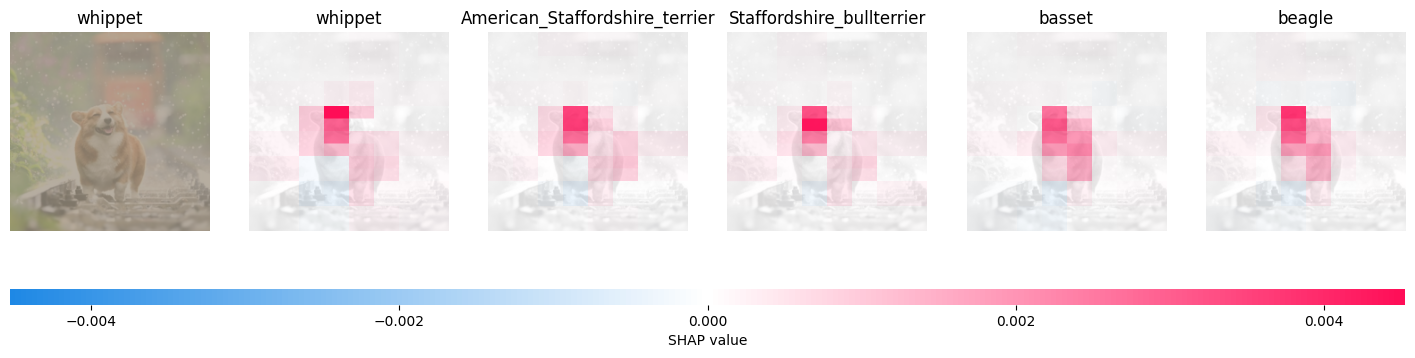

In [13]:
shap.image_plot(shap_values=shap_values.values, 
                pixel_values=shap_values.data, 
                labels=shap_values.output_names,
                true_labels=[class_names[output.argmax()]])

## Effect of Different Inpainting Methods

- TODO: make a list of the masks
- iterate through the lists
- show top 5 classes
- TODO: look for 5 papers

In [14]:
# define a masker that is used to mask out partitions of the input image. 
mask_names = ["inpaint_telea", "inpaint_ns", "blur(128, 128)", "blur(16, 16)"]

masks = [shap.maskers.Image(m, shape = img_tensor2[0].shape) for m in mask_names]

  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:33, 33.49s/it]                                                                                                  


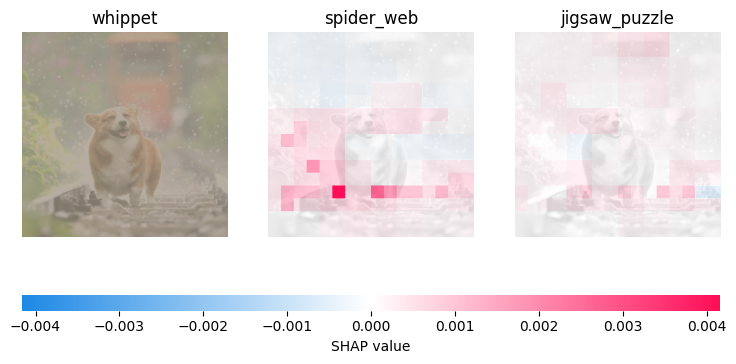

  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:31, 31.68s/it]                                                                                                  


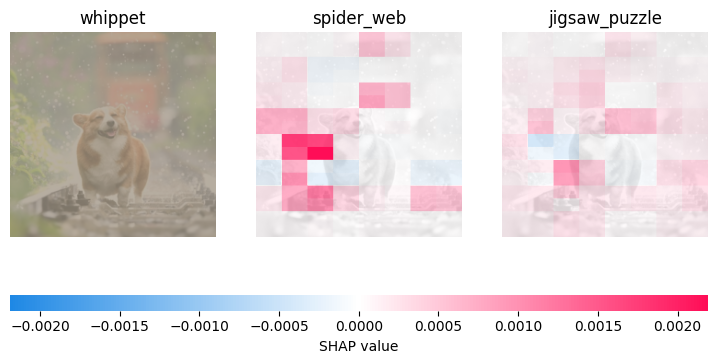

  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:31, 31.04s/it]                                                                                                  


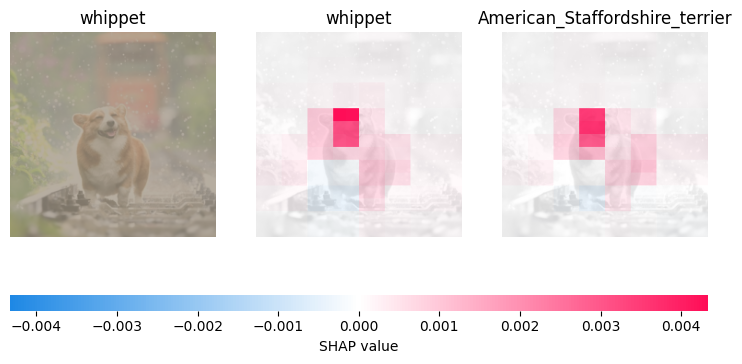

  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:27, 27.18s/it]                                                                                                  


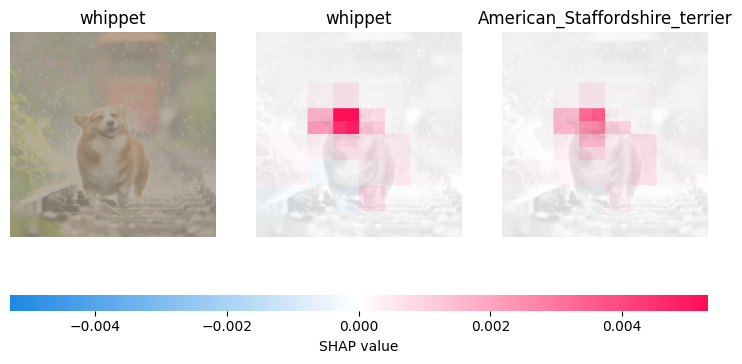

In [15]:
topk = 2

for mask in masks:
    # create an explainer with model and image masker 
    explainer = shap.Explainer(predict, mask, output_names=class_names)
    # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
    shap_values = explainer(img_tensor2, max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:topk])
    shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
    shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]
    shap.image_plot(shap_values=shap_values.values, 
                pixel_values=shap_values.data, 
                labels=shap_values.output_names,
                true_labels=[class_names[output.argmax()]])
    

# DeepExplainer

We can do all the same but on a pixel level. Depending on your application, this can make sense. But it's expensive.

It makes sense if you need a really fine-grained explanation.

Instead of an "Explainer" object, we create a "DeepExplainer". This also means we need no masker, but we will again work with the background data.

But here's the thing: Which data to use.
Since I haven't trained the model myself, I have to think hard on what the background data is.
Usually it would be from the same distribution as my usual data. 

But that's super slow, I see no point in using it.
